In [2]:
import pickle as pkl
import random
import sys
import warnings
from collections import OrderedDict
from glob import glob
from pathlib import Path
import csv
import time
from typing import Callable, Dict, Optional, Tuple
import os
import brevitas
import brevitas.nn as qnn
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from brevitas import config
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
from concrete.fhe.compilation import Configuration
from sklearn.metrics import top_k_accuracy_score
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

from concrete.fhe import Exactness
from concrete.ml.torch.compile import compile_brevitas_qat_model, compile_torch_model

warnings.filterwarnings("ignore", category=UserWarning)


from cifar_utils import (
    fhe_compatibility,
    get_dataloader,
    mapping_keys,
    plot_baseline,
    plot_dataset,
    torch_inference,
    train,
)

<!> Since MNIST is a relatively simple task, training a floating-point model and then fine-tuning the quantized model yields the same results as training the quantized model from scratch.

- If we train first the FP32, then assign the weights to the Brevitas model, and finally finetune it, we save like  10 epochs 

<!> That's why the following cell is disabled.

In [3]:
INPUT_IMG_SIZE = 28

FEATURES_MAPS = [
    ("I",),
    # Padding tuple (left, right, top, bottom), mode 
    # ("P", (1, 1, 1, 1), 'replicate'),   
    # ("I",),  
    # Layer 1: INPUT_IMG_SIZE, out_size, kernel_size=t[3], stride=t[4], padding=t[5], padding_mode="replicate")
    ("C", 1, 1, 3, 0, 1, "replicate"),
]


# In the paper, we have 17 identity layers (frozen layers)
LINEAR_LAYERS = lambda nb_layers: (
    [("R",), ("L", INPUT_IMG_SIZE * INPUT_IMG_SIZE, 92),  ("I",), ("B", 92), ("I",),] + \
    [("R",), ("L", 92, 92),  ("I",), ("B", 92), ("I",),] * (nb_layers - 2) + [("L", 92, 10)]
)

In [4]:
class ReplicatePad2d(nn.Module):
    def __init__(self, padding, mode):
        super(ReplicatePad2d, self).__init__()
        self.padding = padding  # padding is expected as a tuple (left, right, top, bottom)
        self.mode = mode

    def forward(self, x):
        return nn.functional.pad(x, self.padding, mode=self.mode)

In [5]:
class Fp32MNIST(nn.Module):
    def __init__(self, output_size: int, nb_layers: int):
        super(Fp32MNIST, self).__init__()
        """ Torch model.

        Args:
            output_size (int): Number of classes.
        """
        self.output_size = output_size
        self.nb_layers = nb_layers

        def make_layers(t):

            if t[0] == "P":
                return ReplicatePad2d(t[1], t[2])
            elif t[0] == "C":
                return nn.Conv2d(1, 1, kernel_size=3, stride=1)
            elif t[0] == "L":
                return nn.Linear(in_features=t[1], out_features=t[2])
            elif t[0] == "R":
                return nn.ReLU()
            elif t[0] == "F":
                return nn.Flatten(1, -1)
            elif t[0]:
                return nn.BatchNorm1d(t[1])
            else:
                raise NameError(f"{t} not defined")

        self.features_maps = nn.Sequential(*[make_layers(t) for t in FEATURES_MAPS if t[0] != "I"])
        self.linears = nn.Sequential(*[make_layers(t) for t in LINEAR_LAYERS(self.nb_layers) if t[0] != "I"])

    def forward(self, x):
        x = self.features_maps(x)
        x = nn.Flatten()(x)
        x = self.linears(x)
        return x

In [6]:
class QuantMNIST(nn.Module):
    def __init__(
        self,
        bit: int,
        output_size: int = 10,
        nb_layers: int = 20, 
        act_quant: brevitas.quant = Int8ActPerTensorFloat,
        weight_quant: brevitas.quant = Int8WeightPerTensorFloat,
    ):
        """A quantized network with Brevitas.

        Args:
            bit (int): Bit of quantization.
            output_size (int): Number of classes.
            act_quant (brevitas.quant): Quantization protocol of activations.
            weight_quant (brevitas.quant): Quantization protocol of the weights.

        """
        super(QuantMNIST, self).__init__()
        self.bit = bit
        self.nb_layers = nb_layers

        def tuple2quantlayer(t):
            if t[0] == "P":
                return ReplicatePad2d(t[1], t[2])
            if t[0] == "R":
                return qnn.QuantReLU(return_quant_tensor=True, bit_width=bit, act_quant=act_quant)
            if t[0] == "C":
                return qnn.QuantConv2d(
                    t[1],
                    t[2],
                    kernel_size=t[3],
                    # stride=t[4],
                    weight_bit_width=2,
                    weight_quant=weight_quant,
                    return_quant_tensor=True,
                )
            if t[0] == "L":
                return qnn.QuantLinear(
                    in_features=t[1],
                    out_features=t[2],
                    weight_bit_width=bit,
                    weight_quant=weight_quant,
                    bias=True,
                    return_quant_tensor=True,
                )
            if t[0] == "I":
                identity_quant = t[1] if len(t) == 2 else bit
                return qnn.QuantIdentity(
                    bit_width=identity_quant, act_quant=act_quant, return_quant_tensor=True
                )
            if t[0] == "B":
                return nn.BatchNorm1d(t[1])

        self.features_maps = nn.Sequential(
            *[tuple2quantlayer(t) for t in FEATURES_MAPS if t[0] != "I"]
        )

        # self.identity1 and self.identity2 are used to encapsulate the `torch.flatten`.
        self.identity1 = qnn.QuantIdentity(
            bit_width=bit, act_quant=act_quant, return_quant_tensor=True
        )

        self.identity2 = qnn.QuantIdentity(
            bit_width=bit, act_quant=act_quant, return_quant_tensor=True
        )

        self.linears = nn.Sequential(*[tuple2quantlayer(t) for t in LINEAR_LAYERS(self.nb_layers) if t[0] != "I"])

    def forward(self, x):
        x = self.features_maps(x)
        x = self.identity1(x)
        x = torch.flatten(x, 1)
        x = self.identity2(x)
        x = self.linears(x)
        return x.value

In [11]:
def run(fp32_model, quant_model, compile_type, data_calibration, data_loader, bits=None):

    bits = quant_model.bit if compile_type == "qat" else bits
    model = quant_model if compile_type == "qat" else fp32_model 
    nb_layers = quant_model.nb_layers
    compile_function = compile_brevitas_qat_model if compile_type == "qat" else compile_torch_model



    print(f"{nb_layers=}, {bits=}, {compile_type=}, {compile_function=}")

    history = []

    filename = f"history_{nb_layers=}_v2.csv"
    headers = ["Compile_Type", "Number_of_Layers", "Bits", "Threshold", "Max_Bits",
               "Mean_FP32_Accuracy", "Mean_Disable_Accuracy", "Mean_Simulate_Accuracy", "FHE_Timing"]

    if not os.path.isfile(filename):
        print("NEW FILE")
        with open(filename, "w", newline='') as file:
            writer = csv.writer(file)
            writer.writerow(headers)

    with open(filename, "a", newline='') as file:
        writer = csv.writer(file)

        for j, threshold in tqdm(enumerate([7, 6, 5, 4, Exactness.APPROXIMATE, Exactness.EXACT])):

            history_fp32_predictions = [] 
            history_disable_predictions = [] 
            history_simulat_predictions = [] 
            fhe_timing = 0

            if 4: 
                key = f"{compile_type} | layers={nb_layers} | {bits=} | {threshold=}"
                q_module = compile_function(
                    model.to("cpu"),
                    torch_inputset=data_calibration,
                    n_bits=None if compile_type == "qat" else bits,
                    rounding_threshold_bits=threshold,
                )

                max_bits = q_module.fhe_circuit.graph.maximum_integer_bit_width()
                print(f"{j=}: {max_bits=}")

                for i, (data, labels) in tqdm(enumerate(data_loader)):
                    
                    fp32_predictions = model(data).cpu().detach()
                    history_fp32_predictions.extend(fp32_predictions.argmax(1) == labels)
                    
                    data, labels = data.detach().cpu().numpy(), labels.detach().cpu().numpy()

                    disable_predictions = q_module.forward(data, fhe="disable")
                    history_disable_predictions.extend(disable_predictions.argmax(1) == labels)

                    simulat_predictions = q_module.forward(data, fhe="simulate")
                    history_simulat_predictions.extend(simulat_predictions.argmax(1) == labels)

                    if i == 0:
                        start_time = time.time()
                        q_module.forward(data[0, None], fhe="execute")
                        fhe_timing = ((time.time() - start_time) / 60.0)

                row = [
                    compile_type,
                    nb_layers,
                    bits,
                    threshold,
                    max_bits,
                    np.mean(history_fp32_predictions),
                    np.mean(history_disable_predictions),
                    np.mean(history_simulat_predictions),
                    fhe_timing
                ]

            else:
                row = [compile_type, nb_layers, bits, threshold, -1, -1, -1, -1, -1]

            writer.writerow(row)
            print(f"{j=}: {row=}")
            history.append(dict(zip(headers, row)))

    return history

Train the model

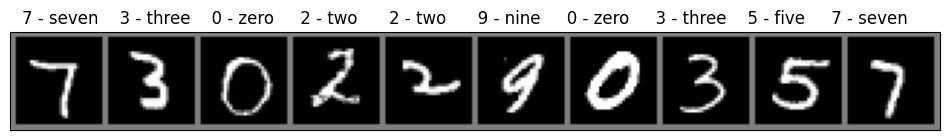

torch.Size([64, 1, 30, 30])

In [8]:
device =  "cpu"

param = {
    "output_size": 10,
    "batch_size": 64,
    "dataset_name": "MNIST",
    "dataset": datasets.MNIST,
    "training": "fp32",
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "seed": 42,
}

train_loader, test_loader = get_dataloader(param=param)

data_calibration = next(iter(train_loader))[0]

plot_dataset(test_loader, param)

data_calibration.shape

# FP32 MNIST 20

In [ ]:
nb_layers = 20

param["dir"] =  f"./checkpoints/MNIST/NLP_{nb_layers}/",

fp32_mnist_20 = Fp32MNIST(param['output_size'], nb_layers=nb_layers).to(device)

In [ ]:
run = False

if run:
    param["training"] = "fp32"
    param["epochs"] = 30
    param["lr"] = 0.01
    param["milestones"] = [15, 24]
    param["gamma"] = 0.1

    fp32_mnist = train(fp32_mnist_20, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 0.6650 VS Test loss = 0.5419 - Accuracy train: 0.7971 VS Accuracy test: 0.8859
Epoch  1: Train loss = 0.3863 VS Test loss = 0.3187 - Accuracy train: 0.9059 VS Accuracy test: 0.9206
Epoch  2: Train loss = 0.2996 VS Test loss = 0.4548 - Accuracy train: 0.9283 VS Accuracy test: 0.9050
Epoch  3: Train loss = 0.2683 VS Test loss = 0.5307 - Accuracy train: 0.9369 VS Accuracy test: 0.8632
Epoch  4: Train loss = 0.2703 VS Test loss = 0.2626 - Accuracy train: 0.9358 VS Accuracy test: 0.9562
Epoch  5: Train loss = 0.2228 VS Test loss = 0.2361 - Accuracy train: 0.9484 VS Accuracy test: 0.9625
Epoch  6: Train loss = 0.2047 VS Test loss = 0.2350 - Accuracy train: 0.9521 VS Accuracy test: 0.9642
Epoch  7: Train loss = 0.2016 VS Test loss = 0.1999 - Accuracy train: 0.9522 VS Accuracy test: 0.9585
Epoch  8: Train loss = 0.1762 VS Test loss = 0.1687 - Accuracy train: 0.9576 VS Accuracy test: 0.9690
Epoch  9: Train loss = 0.1819 VS Test loss = 0.1779 - Accuracy train: 0.9567 VS Ac

In [ ]:
# Sanity check
checkpoint = torch.load(f"checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=device)

fp32_mnist = Fp32MNIST(param['output_size'], nb_layers=nb_layers).to(device)

fp32_mnist.load_state_dict(checkpoint)

acc_after_ft_train = torch_inference(fp32_mnist, train_loader, device=device)
acc_after_ft_test  = torch_inference(fp32_mnist, test_loader, device=device)

print(
    f"With {fp32_mnist.nb_layers}-nb_layers: "
    f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
    )

With 20-nb_layers: acc_after_ft_train=99.310% vs acc_after_ft_test=98.137%


## Quant MNIST 20

In [ ]:
# bits, run, nb_layers = 3, False, 20

# quant_mnist = QuantMNIST(bit=bits, output_size=param["output_size"], nb_layers=nb_layers).to("cpu")
# quant_mnist = mapping_keys(checkpoint, quant_mnist, device="cpu")
# acc_before_ft = torch_inference(quant_mnist, test_loader, device=device)

# print(f"Accuracy before fine-tuning: {acc_before_ft=:.3%}")
# qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)
# print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

# # if run:
# #     param["training"] = f"quant_mnist_{bits=}"
# #     param["epochs"] = 9
# #     param["lr"] = 0.1
# #     param["milestones"] = [3]
# #     param["gamma"] = 0.1
# #     quant_mnist = train(quant_mnist, train_loader, test_loader, param, device=device)

# path = f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"

# quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
# quant_mnist.load_state_dict(torch.load(path, map_location=device))

# acc_after_ft_train = torch_inference(quant_mnist, train_loader, device=device)
# acc_after_ft_test  = torch_inference(quant_mnist, test_loader, device=device)

# print(
#     f"With {quant_mnist.bit}-bits and {quant_mnist.nb_layers}-nb_layers: "
#     f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
#     )

# qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)
# print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

In [ ]:
bits, run, nb_layers = 4, False, 20

quant_mnist = QuantMNIST(bit=bits, output_size=param["output_size"], nb_layers=nb_layers).to("cpu")
quant_mnist = mapping_keys(checkpoint, quant_mnist, device="cpu")
acc_before_ft = torch_inference(quant_mnist, test_loader, device=device)

print(f"Accuracy before fine-tuning: {acc_before_ft=:.3%}")
qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)
print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

# if run:
#     param["training"] = f"quant_mnist_{bits=}"
#     param["epochs"] = 5
#     param["lr"] = 0.1
#     param["milestones"] = [1, 3]
#     param["gamma"] = 0.1

#     quant_mnist_20 = train(quant_mnist_20, train_loader, test_loader, param, device=device)

path = f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"

quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
quant_mnist.load_state_dict(torch.load(path, map_location=device))

acc_after_ft_train = torch_inference(quant_mnist, train_loader, device=device)
acc_after_ft_test  = torch_inference(quant_mnist, test_loader, device=device)

print(
    f"With {quant_mnist.bit}-bits and {quant_mnist.nb_layers}-nb_layers: "
    f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
    )

qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)
print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

Accuracy before fine-tuning: acc_before_ft=9.746%
Maximum bit-width in the circuit: 13

With 4-bits and 20-nb_layers: acc_after_ft_train=97.322% vs acc_after_ft_test=97.165%
Maximum bit-width in the circuit: 13



In [ ]:
bits = 5
path = f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"

quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
quant_mnist.load_state_dict(torch.load(path, map_location=device))

acc_after_ft_train = torch_inference(quant_mnist, train_loader, device=device)
acc_after_ft_test  = torch_inference(quant_mnist, test_loader, device=device)

print(
    f"With {quant_mnist.bit}-bits and {quant_mnist.nb_layers}-nb_layers: "
    f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
    )

qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)
print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

## Run mnist nlp20

In [ ]:

bits = 4
nb_layers = 20

param["dir"] =  f"./checkpoints/MNIST/NLP_{nb_layers}/"
checkpoint = torch.load(f"checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=device)
fp32_mnist = Fp32MNIST(param['output_size'], nb_layers=nb_layers).to(device)
fp32_mnist.load_state_dict(checkpoint)

path = f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
quant_mnist.load_state_dict(torch.load(path, map_location=device))

history = run(fp32_mnist, quant_mnist, 'ptq', data_calibration, test_loader, bits=5)

In [ ]:
df = pd.read_csv("history_nb_layers=20.csv")

df

,Compile_Type,Number_of_Layers,Bits,Threshold,Max_Bits,Mean_FP32_Accuracy,Mean_Quant_Accuracy,FHE_Timing
0,ptq,20,4,7,13,0.093750,0.093750,4.896937
1,ptq,20,4,6,11,0.125000,0.125000,2.280711
2,ptq,20,4,4,-1,-1.000000,-1.000000,-1.000000
3,ptq,20,4,Exactness.EXACT,-1,-1.000000,-1.000000,-1.000000
4,ptq,20,4,Exactness.APPROXIMATE,-1,-1.000000,-1.000000,-1.000000
5,ptq,20,3,Exactness.EXACT,-1,-1.000000,-1.000000,-1.000000
6,ptq,20,3,Exactness.APPROXIMATE,-1,-1.000000,-1.000000,-1.000000
7,ptq,20,5,Exactness.EXACT,-1,-1.000000,-1.000000,-1.000000
8,ptq,20,5,Exactness.APPROXIMATE,-1,-1.000000,-1.000000,-1.000000
9,ptq,20,5,7,15,0.093750,0.093750,6.051062


In [ ]:
history = run(fp32_mnist, quant_mnist, 'qat', data_calibration, test_loader, bits=4)


nb_layers=20, bits=4, compile_type='qat', compile_function=<function compile_brevitas_qat_model at 0x7f049a7496c0>


0it [00:00, ?it/s]

j=0: max_bits=14


156it [09:08,  3.52s/it]
1it [09:14, 554.89s/it]

j=0: row=['qat', 20, 4, 7, 14, 0.984375, 0.984375, 6.450424118836721]
j=1: max_bits=14


156it [04:58,  1.91s/it]
2it [14:19, 407.38s/it]

j=1: row=['qat', 20, 4, 6, 14, 0.9375, 0.9375, 2.2608179012934366]
j=2: max_bits=14


156it [04:11,  1.61s/it]
3it [18:36, 338.78s/it]

j=2: row=['qat', 20, 4, 5, 14, 0.890625, 0.890625, 1.4983412265777587]
j=3: max_bits=13


156it [04:04,  1.57s/it]
4it [22:46, 303.89s/it]

j=3: row=['qat', 20, 4, 4, 13, 0.828125, 0.828125, 1.3873843431472779]
x.bit_width=10 > lsbs_to_remove=12


5it [22:50, 195.68s/it]

j=4: row=['qat', 20, 4, <Exactness.EXACT: 0>, -1, -1, -1, -1, -1]
x.bit_width=11 > lsbs_to_remove=11


6it [22:54, 229.03s/it]

j=5: row=['qat', 20, 4, <Exactness.APPROXIMATE: 1>, -1, -1, -1, -1, -1]


In [ ]:
history2 = run(fp32_mnist, quant_mnist, 'ptq', data_calibration, test_loader, bits=5)

nb_layers=20, bits=5, compile_type='ptq', compile_function=<function compile_torch_model at 0x7f049a7495a0>


0it [00:00, ?it/s]

j=0: max_bits=13


156it [08:47,  3.38s/it]
1it [08:51, 531.63s/it]

j=0: row=['ptq', 20, 5, 7, 13, 0.09375, 0.09375, 6.47584156592687]
j=1: max_bits=13


156it [05:57,  2.29s/it]
2it [14:54, 432.18s/it]

j=1: row=['ptq', 20, 5, 6, 13, 0.046875, 0.046875, 3.6759230732917785]
j=2: max_bits=13


156it [04:33,  1.75s/it]
3it [19:31, 361.69s/it]

j=2: row=['ptq', 20, 5, 5, 13, 0.078125, 0.078125, 2.2676265637079873]
j=3: max_bits=13


156it [04:30,  1.73s/it]
4it [24:07, 327.62s/it]

j=3: row=['ptq', 20, 5, 4, 13, 0.03125, 0.03125, 2.193187900384267]
x.bit_width=1 > lsbs_to_remove=1


5it [24:10, 210.48s/it]

j=4: row=['ptq', 20, 5, <Exactness.EXACT: 0>, -1, -1, -1, -1, -1]
j=5: max_bits=14


156it [04:47,  1.84s/it]
6it [29:03, 290.62s/it]

j=5: row=['ptq', 20, 5, <Exactness.APPROXIMATE: 1>, 14, 0.015625, 0.015625, 2.4788689692815145]


In [ ]:
history2 = run(fp32_mnist, quant_mnist, 'ptq', data_calibration, test_loader, bits=3)

nb_layers=20, bits=3, compile_type='ptq', compile_function=<function compile_torch_model at 0x7f049a7495a0>


0it [00:00, ?it/s]

j=0: max_bits=9


156it [05:05,  1.96s/it]
1it [05:10, 310.45s/it]

j=0: row=['ptq', 20, 3, 7, 9, 0.078125, 0.0625, 2.806963606675466]
j=1: max_bits=9


156it [03:53,  1.50s/it]
2it [09:08, 267.74s/it]

j=1: row=['ptq', 20, 3, 6, 9, 0.109375, 0.09375, 1.6173099716504415]
j=2: max_bits=9


156it [03:10,  1.22s/it]
3it [12:22, 234.23s/it]

j=2: row=['ptq', 20, 3, 5, 9, 0.09375, 0.09375, 0.8691867828369141]
j=3: max_bits=9


156it [02:59,  1.15s/it]
4it [15:26, 214.21s/it]

j=3: row=['ptq', 20, 3, 4, 9, 0.046875, 0.046875, 0.7026218215624491]
x.bit_width=1 > lsbs_to_remove=1


5it [15:28, 137.95s/it]

j=4: row=['ptq', 20, 3, <Exactness.EXACT: 0>, -1, -1, -1, -1, -1]
j=5: max_bits=10


156it [03:15,  1.25s/it]
6it [18:48, 188.05s/it]

j=5: row=['ptq', 20, 3, <Exactness.APPROXIMATE: 1>, 10, 0.15625, 0.15625, 0.9648106932640076]


In [ ]:
bits = 5
nb_layers = 20

param["dir"] =  f"./checkpoints/MNIST/NLP_{nb_layers}/"

fp32_mnist = Fp32MNIST(param['output_size'], nb_layers=nb_layers).to(device)

path = f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
quant_mnist.load_state_dict(torch.load(path, map_location=device))

history = run(fp32_mnist, quant_mnist, 'qat', data_calibration, test_loader, bits=4)


nb_layers=20, bits=5, compile_type='qat', compile_function=<function compile_brevitas_qat_model at 0x7f049a7496c0>


0it [00:00, ?it/s]

j=0: max_bits=16


156it [10:04,  3.88s/it]
1it [10:10, 610.72s/it]

j=0: row=['qat', 20, 5, 7, 16, 0.90625, 0.90625, 7.3796510934829715]
j=1: max_bits=16


156it [05:46,  2.22s/it]
2it [16:02, 458.54s/it]

j=1: row=['qat', 20, 5, 6, 16, 0.984375, 0.984375, 3.0753005305926004]
j=2: max_bits=16


156it [05:04,  1.95s/it]
3it [21:13, 390.99s/it]

j=2: row=['qat', 20, 5, 5, 16, 0.9375, 0.9375, 2.413205846150716]
j=3: max_bits=16


156it [04:26,  1.71s/it]
4it [25:47, 344.72s/it]

j=3: row=['qat', 20, 5, 4, 16, 0.515625, 0.421875, 1.767675773302714]
x.bit_width=1 > lsbs_to_remove=16


5it [25:51, 221.82s/it]

j=4: row=['qat', 20, 5, <Exactness.EXACT: 0>, -1, -1, -1, -1, -1]
x.bit_width=12 > lsbs_to_remove=14


6it [25:54, 259.15s/it]

j=5: row=['qat', 20, 5, <Exactness.APPROXIMATE: 1>, -1, -1, -1, -1, -1]


In [ ]:
history = run(fp32_mnist, quant_mnist, 'qat', data_calibration, test_loader, bits=4)


In [15]:
history

[{'Compile Type': 'qat',
  'Number of Layers': 20,
  'Bits': 4,
  'Threshold': 7,
  'Max Bits': -1,
  'Mean FP32 Accuracy': -1,
  'Mean Quant Accuracy': -1,
  'FHE Timing': -1},
 {'Compile Type': 'qat',
  'Number of Layers': 20,
  'Bits': 4,
  'Threshold': 6,
  'Max Bits': -1,
  'Mean FP32 Accuracy': -1,
  'Mean Quant Accuracy': -1,
  'FHE Timing': -1},
 {'Compile Type': 'qat',
  'Number of Layers': 20,
  'Bits': 4,
  'Threshold': 5,
  'Max Bits': -1,
  'Mean FP32 Accuracy': -1,
  'Mean Quant Accuracy': -1,
  'FHE Timing': -1},
 {'Compile Type': 'qat',
  'Number of Layers': 20,
  'Bits': 4,
  'Threshold': 4,
  'Max Bits': -1,
  'Mean FP32 Accuracy': -1,
  'Mean Quant Accuracy': -1,
  'FHE Timing': -1},
 {'Compile Type': 'qat',
  'Number of Layers': 20,
  'Bits': 4,
  'Threshold': <Exactness.APPROXIMATE: 1>,
  'Max Bits': -1,
  'Mean FP32 Accuracy': -1,
  'Mean Quant Accuracy': -1,
  'FHE Timing': -1},
 {'Compile Type': 'qat',
  'Number of Layers': 20,
  'Bits': 4,
  'Threshold': <Exact

In [21]:
bits = 5
nb_layers = 20

param["dir"] =  f"./checkpoints/MNIST/NLP_{nb_layers}/"

fp32_mnist = Fp32MNIST(param['output_size'], nb_layers=nb_layers).to(device)


path = f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
quant_mnist.load_state_dict(torch.load(path, map_location=device))


history3 = run(fp32_mnist, quant_mnist, 'qat', data_calibration, test_loader, bits=4)
history4 = run(fp32_mnist, quant_mnist, 'ptq', data_calibration, test_loader, bits=4)

nb_layers=20, bits=5, compile_type='qat', compile_function=<function compile_brevitas_qat_model at 0x7f19ceed5bd0>


0it [00:00, ?it/s]

j=0: max_bits=16


: 

: 

In [ ]:
bits = 4
nb_layers = 50

param["dir"] =  f"./checkpoints/MNIST/NLP_{nb_layers}/"

fp32_mnist = Fp32MNIST(param['output_size'], nb_layers=nb_layers).to(device)


path = f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
quant_mnist.load_state_dict(torch.load(path, map_location=device))


history35 = run(fp32_mnist, quant_mnist, 'qat', data_calibration, test_loader, bits=4)
history47 = run(fp32_mnist, quant_mnist, 'ptq', data_calibration, test_loader, bits=4)

## MNIST 50

In [15]:
nb_layers = 50

param["dir"] =  f"./checkpoints/MNIST/NLP_{nb_layers}/"

fp32_mnist = Fp32MNIST(param['output_size'], nb_layers=nb_layers).to(device)
checkpoint = torch.load(f"checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=device)
fp32_mnist.load_state_dict(checkpoint)

acc_after_ft_train = torch_inference(fp32_mnist, train_loader, device=device)
acc_after_ft_test  = torch_inference(fp32_mnist, test_loader, device=device)

print(
    f"With {fp32_mnist.nb_layers}-nb_layers: "
    f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
    )


With 50-nb_layers: acc_after_ft_train=98.012% vs acc_after_ft_test=96.855%


In [51]:
bits, run, nb_layers = 4, True, 50

quant_mnist = QuantMNIST(bit=bits, output_size=param["output_size"], nb_layers=nb_layers).to("cpu")
quant_mnist = mapping_keys(checkpoint, quant_mnist, device="cpu")
acc_before_ft = torch_inference(quant_mnist, test_loader, device=device)

"""
Accuracy before fine-tuning: acc_before_ft=10.286%
Maximum bit-width in the circuit: 16
"""

print(f"Accuracy before fine-tuning: {acc_before_ft=:.3%}")
qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)
print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

Accuracy before fine-tuning: acc_before_ft=9.696%
Maximum bit-width in the circuit: 14



In [52]:
path = f"checkpoints/MNIST/NLP_{nb_layers}/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
print(path)
quant_mnist = QuantMNIST(bit=bits, nb_layers=nb_layers).to("cpu")
quant_mnist.load_state_dict(torch.load(path, map_location=device))

# acc_after_ft_train = torch_inference(quant_mnist, train_loader, device=device)
# acc_after_ft_test  = torch_inference(quant_mnist, test_loader, device=device)

# print(
#     f"With {quant_mnist.bit}-bits and {quant_mnist.nb_layers}-nb_layers: "
#     f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
#     )

# qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)
# print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

checkpoints/MNIST/NLP_50/quant_mnist_bits=4/MNIST_quant_mnist_bits=4_state_dict.pt


<All keys matched successfully>

In [54]:
assert str(quant_mnist.nb_layers) in param["dir"]

if run:
    param["training"] = f"quant_mnist_{bits=}"
    param["epochs"] = 5
    param["lr"] = 0.000001
    param["milestones"] = []
    param["gamma"] = 0.1
    quant_mnist = train(quant_mnist, train_loader, test_loader, param, device=device)


Epoch  0: Train loss = 0.4400 VS Test loss = 0.6100 - Accuracy train: 0.8940 VS Accuracy test: 0.8411
Epoch  1: Train loss = 0.4530 VS Test loss = 0.3802 - Accuracy train: 0.8917 VS Accuracy test: 0.9366
Epoch  2: Train loss = 0.4523 VS Test loss = 0.5532 - Accuracy train: 0.8917 VS Accuracy test: 0.7930
Epoch  3: Train loss = 0.4462 VS Test loss = 0.4610 - Accuracy train: 0.8922 VS Accuracy test: 0.9114
Epoch  4: Train loss = 0.4488 VS Test loss = 0.5657 - Accuracy train: 0.8912 VS Accuracy test: 0.7489
Epoch  5: Train loss = 0.4541 VS Test loss = 0.4020 - Accuracy train: 0.8917 VS Accuracy test: 0.9104
Epoch  6: Train loss = 0.4468 VS Test loss = 0.5325 - Accuracy train: 0.8920 VS Accuracy test: 0.8685
Epoch  7: Train loss = 0.4451 VS Test loss = 0.4936 - Accuracy train: 0.8929 VS Accuracy test: 0.8282
Epoch  8: Train loss = 0.4484 VS Test loss = 0.5095 - Accuracy train: 0.8922 VS Accuracy test: 0.8144
Epoch  9: Train loss = 0.4426 VS Test loss = 0.5891 - Accuracy train: 0.8925 VS Ac

In [19]:

qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)
print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}\n")

Maximum bit-width in the circuit: 14



## MNIST 100

In [13]:
nb_layers = 100

param["dir"] =  f"./checkpoints/MNIST/NLP_{nb_layers}/"

fp32_mnist = Fp32MNIST(param['output_size'], nb_layers=nb_layers).to(device)

checkpoint = torch.load(f"checkpoints/MNIST/NLP_{nb_layers}/fp32/MNIST_fp32_state_dict.pt", map_location=device)

fp32_mnist.load_state_dict(checkpoint)

acc_after_ft_train = torch_inference(fp32_mnist, train_loader, device=device)
acc_after_ft_test  = torch_inference(fp32_mnist, test_loader, device=device)

print(
    f"With {fp32_mnist.nb_layers}-nb_layers: "
    f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
    )

With 100-nb_layers: acc_after_ft_train=68.967% vs acc_after_ft_test=70.092%


In [20]:
# for name in fp32_mnist:
#     if name in mnist_nlp50 and fp32_mnist[name].size() == mnist_nlp50[name].size():
#         mnist_nlp50[name].copy_(fp32_mnist[name])

# fp32_mnist.load_state_dict(checkpoint)

for n, p in list(fp32_mnist.named_parameters())[0: 95]:
        p.requires_grad = True

# for n, p in list(fp32_mnist.named_parameters())[]:
#         p.requires_grad = True

run = 1

if run:
    param["training"] = "fp32"
    param["epochs"] = 2
    param["lr"] = 0.00001
    param["milestones"] = []
    param["gamma"] = 0.1

    fp32_mnist = train(fp32_mnist, train_loader, test_loader, param, device=device)


acc_after_ft_train = torch_inference(fp32_mnist, train_loader, device=device)
acc_after_ft_test  = torch_inference(fp32_mnist, test_loader, device=device)

print(
    f"With {fp32_mnist.nb_layers}-nb_layers: "
    f"{acc_after_ft_train=:.3%} vs {acc_after_ft_test=:.3%}"
    )


Epoch  0: Train loss = 0.4472 VS Test loss = 0.8814 - Accuracy train: 0.8737 VS Accuracy test: 0.6469
 50%|█████     | 1/2 [00:49<00:49, 49.17s/it]